In [3]:
#import datasets
from aif360.datasets import StandardDataset
from aif360.datasets import CompasDataset
#import fairness metrics
from aif360.datasets import BinaryLabelDataset 
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric



from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import itertools 


#### 0. COMPAS Dataset used as the starting point to get predictions from.

In [4]:
#load COMPAS dataset

try:
    compas = CompasDataset(
        protected_attribute_names=['sex', 'race'],
        privileged_classes=[['Female'], ['Caucasian']], 
        features_to_keep=['age', 'c_charge_degree', 'race', 'age_cat', 
                          'sex', 'priors_count', 'days_b_screening_arrest', 'c_charge_desc'],
        features_to_drop=[],
        categorical_features=['age_cat', 'c_charge_degree', 'c_charge_desc'],
        label_name='two_year_recid'
    )
    print("Dataset loaded successfully!")

    #returns the dataframe and the metadata in a tuple using a function from the compas dataset
    df, meta = compas.convert_to_dataframe()

except Exception as e:
    print(f"Error loading COMPAS dataset: {e}")

Dataset loaded successfully!


#### 0.1 Train a model with the COMPAS dataset 

- 80/20 train/test split
- key point is the extraction of the group membership from this dataset to create an array storing group membership for each instance.

In [5]:
# copy dataset to ensure original remains unchanged
df = df.copy()
#print(df)

#separate features and labels
features = ['race', 'sex', 'priors_count', 'c_charge_degree=F', 'c_charge_degree=M']
target = 'two_year_recid' #binary target where 0 means does not offend, 1 means offends

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

X_test_indices = X_test.index

#retrive each instance's group membership before scaling X_test to make predictions 
#scaling will make it lose the index information to retrieve this information
grp_membership = df.loc[X_test_indices, 'race'].values
print("\n group membership: ", grp_membership, "\n")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(solver='lbfgs')
model.fit(X_train_scaled, y_train)

#predicted class labels 0 or 1
y_pred = model.predict(X_test_scaled)


 group membership:  [1. 1. 0. ... 0. 0. 0.] 



#### 1. From the above classifier, extract three arrays that are inputs for new_metric function

To do: Have three arrays each for predictions, groud truth labels, and group membership from the dataset and model.

Important aspect of this part: indices of each array needs to align such that pred[0] refers to ground_truth[0] and grp_membership[0]. 

The arrays:
1. predictions: positive and negative predictions from the classifier.
2. ground_truth: this is the two_yr_recid column that represents the target variables. So, use y_test which contains ground truth values from the train_test_split for the dataset.
3. grp_membership: array of group membership for each instance containing privileged (label 1 - Caucasian) and non-privileged (label 0 - not Caucasian) as defined by protected attribute of 'race'.


In [6]:
#predictions array
predictions = y_pred 
print("predictions: ", predictions)

#ground truth labels array
ground_truth = y_test.values 
print("ground truth labels: ", ground_truth)

#group membership array defined above where model is trained.
print("group membership: ", grp_membership)

predictions:  [0. 0. 0. ... 0. 0. 0.]
ground truth labels:  [0. 0. 1. ... 0. 1. 1.]
group membership:  [1. 1. 0. ... 0. 0. 0.]


#### 2. Function for the new metric using the three arrays as input.

- The main conceptual idea behind this metric: as a basic starting point, create a classifier level group metric that takes into consideration individual components.
- Assumption: This will allow for a quantification of fairness in a more comprehensive manner. 
- Evaluate behaviour by: giving the function varied distributions of arrays as input.

In [7]:
def new_metric(arr_pred, arr_true, arr_grp): 
    
    #Two arrays for privileged and not privileged 
    #g1 and g2- contain predictions and trues are lists of lists [[], []]
    grp_priv = [[], []]
    grp_unpriv = [[], []]

    #j is the number of unique groups in arr_grp 
    j = len(set(arr_grp)) #!an implicit parameter.
    
    #print("total number of unique groups: ", j)

    for i, label in enumerate(arr_grp):
        #for privileged class
        if label == 1.0:
            #add the corresponding prediction + gt label for that class using the index associated with that label
            grp_priv[0].append(arr_pred[i])
            grp_priv[1].append(arr_true[i])
        
        #for unprivileged class
        else:
            grp_unpriv[0].append(arr_pred[i])
            grp_unpriv[1].append(arr_true[i])
    
    #print("Privileged group: ", grp_priv)
    #print("Unprivileged group: ", grp_unpriv)
    
    priv_indiv_bi = [] #stores individual benefit value of each instance
    priv_grp_bi = 0 #tracks total benefit for group
    
    #1. for each index in a group calculate the benefit, bi
    for pred, gt in zip(grp_priv[0], grp_priv[1]):
        #the individual component from GEI to calculate benefit for each instance in a group
        # original bi calculation with original range of 0,1,2
        indiv_benefit = (int(pred) - int(gt)) + 1
        
        #2. Sum the total benefit of each group
        priv_grp_bi += indiv_benefit
        
        #3. divide by size of group 1 - result of this is for each class
        priv_av_bi = priv_grp_bi / len(grp_priv[0]) #this is the total number of instances in each group. [0] has predictions which will give that number

        #store individual benefit of each instance in a list
        priv_indiv_bi.append(indiv_benefit)

    #print(priv_grp_bi)
    # print(priv_av_bi)
    #print("all bi scores for privileged instances:\n", priv_indiv_bi)

    unpriv_indiv_bi = []
    unpriv_grp_bi = 0
    for pred, gt in zip(grp_unpriv[0], grp_unpriv[1]):
        indiv_benefit = (int(pred) - int(gt)) + 1
        unpriv_grp_bi += indiv_benefit
        unpriv_av_bi = unpriv_grp_bi / len(grp_priv[0])
        unpriv_indiv_bi.append(indiv_benefit)
        
    #print(unpriv_grp_bi)
    #print(unpriv_av_bi)
    #print("all bi scores for unprivileged instances:\n", unpriv_indiv_bi)

    #4. division result is divided by the sum of g1 and g2 - J
    result = (priv_av_bi + unpriv_av_bi) / j

    #print("new metric value: ", result)
    #return priv_av_bi, unpriv_av_bi to see individual benefit for each group in arr_grp
    return result

#print("results from COMPAS data classification:\n", new_metric(predictions, ground_truth, grp_membership))


### 3. Simulate classification results for edge cases and expand table with these numbers

- to see if simulated classifier does good on one group and not on other (priv vs unpriv groups).
- creating arrays with different distrubutions.
- wanting to see if my metric gives more intuitive and interpretable results.
- test cases where metrics act differently using the fake distributions acting as output from classifiers.

### 3.1 Function that generates different array distributions. 

#### The ordering flag:
- It decides how the instances are arranged in the final array.
- It determines whether the array is ordered with all 0s first (ascending) or all 1s first (descending) after the counts have been set.

#### How does the function randomise the arrays?
- given a particular distribution, the function will generate zeroes and ones depending on the distribution and allocate them in random order within the array.
- so for 10 instances and 80/20, 50/50, 80/20 dist combination, the fixed arrays will have 8 zeroes and 2 ones in that order or 5 0s and 5 1s in that order.
- but randomised will have 8 ones and 2 zeroes in any order, same for 5 zeroes and 5 ones.

In [8]:
#function to generate arrays synthetically by using fixed distributions:

#function takes in the size of array and the type of distribution to generate
def array_generator(num_of_instances, grp_dist, true_dist, pred_dist, 
                    # grp_order='asc', true_order='asc', pred_order='asc',
                    randomise=False):
    
    #a dictionary that stores the types of expected distributions and maps to their corresp probabilties
    distribution_mapping = {"50/50": (0.5, 0.5), #50% 0s 50% 1s
                            "80/20": (0.8, 0.2), #80% 0s 20% 1s
                            "90/10": (0.9, 0.1), #90% 0s 10% 1s
                            "70/30": (0.7, 0.3)}

    #get the given parameters of probabilties for each distribution from the dict
    group_probability = distribution_mapping.get(grp_dist)
    gt_probability = distribution_mapping.get(true_dist)
    pred_probability = distribution_mapping.get(pred_dist)

    if randomise:
        arr_grp = np.random.choice([0,1], size=num_of_instances, p=group_probability)
        arr_true = np.random.choice([0,1], size=num_of_instances, p=gt_probability)
        arr_pred = np.random.choice([0,1], size=num_of_instances, p=pred_probability)

    else:
        #calculations for fixing the 0s and 1s for each array using probabilities and array size
        group_zeroes =  int(num_of_instances * group_probability[0])
        group_ones =  num_of_instances - group_zeroes
    
        true_zeroes = int(num_of_instances * gt_probability[0])
        true_ones = num_of_instances - true_zeroes
    
        pred_zeroes = int(num_of_instances * pred_probability[0])
        pred_ones = num_of_instances - pred_zeroes

        arr_grp = np.array([0] * group_zeroes + [1] * group_ones)
        arr_true = np.array([0] * true_zeroes + [1] * true_ones)
        arr_pred = np.array([0] * pred_zeroes + [1] * pred_ones)

        #create predictions array based on desired order of 0s and 1s.
        # if pred_order == 'asc':
        #     arr_pred = np.array([0] * pred_zeroes + [1] * pred_ones)
        # elif pred_order == 'desc':
        #     arr_pred = np.array([1] * pred_zeroes + [0] * pred_ones)
        # else:
        #     raise ValueError("prediction array order must be 'asc' or 'desc'")
    
        # #create ground truth labels array based on desired order of 0s and 1s.
        # if true_order == 'asc':
        #     arr_true = np.array([0] * true_zeroes + [1] * true_ones)
        # elif true_order == 'desc':
        #     arr_true = np.array([1] * true_zeroes + [0] * true_ones)
        # else:
        #     raise ValueError("prediction array order must be 'asc' or 'desc'")
    
        # #create group memberships array based on desired order of 0s and 1s.
        # if grp_order == 'asc':
        #     arr_grp = np.array([0] * group_zeroes + [1] * group_ones)
        # elif grp_order == 'desc':
        #     arr_grp = np.array([1] * group_zeroes + [0] * group_ones)
        # else:
        #     raise ValueError("group membership array order must be 'asc' or 'desc'")
    
    return arr_grp, arr_true, arr_pred  



arr_grp, arr_true, arr_pred = array_generator(20, 
                                              "50/50", 
                                              "50/50", 
                                              "80/20", 
                                              randomise=False)


arr_grp_rand, arr_true_rand, arr_pred_rand = array_generator(20, 
                                                          "50/50", 
                                                          "50/50", 
                                                          "80/20", 
                                                          randomise=True)

print("group membership array: ", arr_grp)
print("grount truth labels array: ", arr_true)
print("predictions array: ", arr_pred)

print("\ngroup membership with randomness: ", arr_grp_rand)
print("grount truth labels with randomness: ", arr_true_rand)
print("predictions with randomness: ", arr_pred_rand)


#checking to see if the desc/asc feature changes the score for the metric:
print("\nmetric score for fixed arrays: ", new_metric(arr_grp, arr_true, arr_pred))
print("metric score for randomised arrays: ",new_metric(arr_grp_rand, arr_true_rand, arr_pred_rand))

group membership array:  [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
grount truth labels array:  [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
predictions array:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]

group membership with randomness:  [0 1 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 0 0 1]
grount truth labels with randomness:  [1 1 0 1 0 1 0 1 0 0 0 1 0 1 1 1 1 1 0 0]
predictions with randomness:  [1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0]

metric score for fixed arrays:  2.5
metric score for randomised arrays:  2.125


### Function to calculate the Balanced Accuracy
- need the true and predicted pair of arrays
- this function takes in two synthetically generated arrays to calculate the BAC score for.
- Aim: To have this score as an anchor point to get an idea of positive and negative outcomes from a classifier.
- the function is used in the 'automate_analysis' function 

In [9]:
from sklearn.metrics import balanced_accuracy_score

def balanced_accuracy(arr_true, arr_pred):
    y_true = arr_true
    y_pred = arr_pred
    return balanced_accuracy_score(y_true, y_pred)

### Function to return a metric object for AIF360 framework
- function returns a metric object that is compatible for the AIF360 framework
- the object can be created in the 'automate_analysis' function to then apply AIF360 metrics to.

#### Experiment using these metrics: Conducting a comparison of synthetic classification results with evaluation metrics in AIF360 

- The goal here is to be able to use the existing metrics from aif360 and get a value for each array distribution.
- Outcome: to have a comparison of my metric with existing metrics and be able to argue that the custom metric is somehow more interpretable and than existing ones. Therefore, making it a more comprehensible metric. 
- Issue: not bring able to give correct inputs to the functions that are needed to apply metrics within the framework.
- Possible solution to do later: use the tutorials as example to see how they give input to these functions and perhaps fake the datasets with the fake arrays to give them as input.

In [10]:
from aif360.datasets import BinaryLabelDataset 
from aif360.metrics import ClassificationMetric

def aif360_metric_object(num_of_instances, arr_grp, arr_true, arr_pred, seed=42):
    
    # synthetic feature data just to comply with AIF360 formatting to apply metric.
    np.random.seed(seed)
    features = pd.DataFrame({
        'feature1': np.random.rand(num_of_instances),
        'feature2': np.random.rand(num_of_instances),
        'race': np.random.randint(0, 2, num_of_instances)  # placeholder protected attribute
    })

    features['race'] = arr_grp #protected attribute to represent the group membership array
    
    #these will be the variables to store the generated arrays with varying distributions 
    #these changing arrays will show the changing score of each metric being applied 

    data_true = features.copy() #dataframe with true labels
    data_true['label'] = arr_true
    
    data_pred = features.copy() #dataframe with predicted labels
    data_pred['label'] = arr_pred
    
    # Create BinaryLabelDataset objects for true and predicted datasets
    dataset_true = BinaryLabelDataset(df=data_true, label_names=['label'], protected_attribute_names=['race'])
    dataset_pred = BinaryLabelDataset(df=data_pred, label_names=['label'], protected_attribute_names=['race'])
    
    privileged_groups = [{'race': 1}]  # represents the majority group
    unprivileged_groups = [{'race': 0}]  # represents the minority group
    
    metric = ClassificationMetric(dataset_true, dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    return metric
    
#aif360_metric = aif360_metric_object(num_of_instances, arr_grp, arr_true, arr_pred)

#### Function to automate analysis process

- function needs to be able to create different combinations of distributions to give as input to the function that generates arrays.
- store the generated arrays in variables
- give those variables as input to the custom metrics and store the score in a variable
- give pred and true arrays as input to other exisitng metrics and get a score in variables that correspond to each metric.
- get BAC similarly
- have a list of scores associated with that distribution
- add that as a row to the pandas dataframe and export it to latex
- use the distribution combination as the naming scheme for the 'approach' that has all the scores associated with it.
- returns the dataframe - a table showing the scores for each metric given  arrays with different distributions.

In [29]:
import itertools 
def automate_analysis(num_of_instances,  dist_types=[], randomise=False):
  
    #order_type = ["asc", "desc"] 
 
    results = []

    #number 43 and not convention number 42 because the latter gives a division by zero error
    if randomise:
        np.random.seed(43)
        
    #grp_order, true_order, pred_order, order_type, order_type, order_type removed.
    for (grp_dist, true_dist, pred_dist) in itertools.product(dist_types, dist_types, dist_types):
        # #generate array for current combination
        arr_grp, arr_true, arr_pred = array_generator(num_of_instances, 
                                                      grp_dist=grp_dist, 
                                                      true_dist=true_dist, 
                                                      pred_dist=pred_dist,
                                                      randomise=randomise)
        
        balanced_accuracy_score = balanced_accuracy(arr_true, arr_pred)
        standard_custom_metric = new_metric(arr_grp, arr_true, arr_pred)
        
        aif360_metric = aif360_metric_object(num_of_instances, arr_grp, arr_true, arr_pred, seed=42)
        gei_score = aif360_metric.generalized_entropy_index()
        statistical_parity_diff = aif360_metric.mean_difference()
        disparate_impact = aif360_metric.disparate_impact()
        eq_opp_diff =  aif360_metric.equal_opportunity_difference()
        # av_odds_diff = aif360_metric.average_odds_difference()
        theil_index = aif360_metric.theil_index()
        false_positive_rate = aif360_metric.false_positive_rate()

        
        results.append({
            "grp_dist":grp_dist,
            "true_dist": true_dist,
            "pred_dist": pred_dist,
            "BAC": balanced_accuracy_score,
            "Custom Metric": standard_custom_metric,                    
            "GEI": gei_score,
            "statistical_parity_diff":statistical_parity_diff,
            "disparate_impact": disparate_impact,
            "eq_opp_diff":eq_opp_diff, 
            # "av_odds_diff":av_odds_diff,
             "theil_index": theil_index,
            "false_positive_rate": false_positive_rate
        })

    #create pandas dataframe from the results list
    metrics_df = pd.DataFrame(results)
    return metrics_df

num_of_instances = 100
dist_types = ["50/50", "80/20", "90/10", "70/30"] #removed 10/90, 20/80 because they just overlap with the same values
#fixed_metrics_scores_table = automate_analysis(num_of_instances, dist_types, randomise=False)
#fixed_latex_table = fixed_metrics_scores_table.to_latex(index=False)

#pd.set_option('display.max_rows', None) #to display all rows of table.
#fixed_metrics_scores_table.iloc[16:25]

random_metrics_scores_table = automate_analysis(num_of_instances, dist_types, randomise=True)
#random_latex_table = random_metrics_scores_table.to_latex(index=False)
#random_latex_table

#random_metrics_scores_table.iloc[:16]


In [21]:
#replace inf with NaN values and drop those columns
def clean_dataframe(df, columns):
    clean_df = df.copy()
    for col in columns:
        clean_df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
    clean_df.dropna(subset=columns, inplace=True)
    
    return clean_df

columns = [ "BAC",
            "Custom Metric",                  
            "GEI",
            "statistical_parity_diff",
            "disparate_impact",
            "eq_opp_diff", 
           "theil_index", 
           "false_positive_rate" ]

# print(fixed_metrics_scores_table[columns].isna().sum())
# print(np.isinf(fixed_metrics_scores_table[columns]).sum())

# print(random_metrics_scores_table[columns].isna().sum())
# print(np.isinf(random_metrics_scores_table[columns]).sum())

#clean_fixed_table = clean_dataframe(fixed_metrics_scores_table, columns)
clean_random_table = clean_dataframe(random_metrics_scores_table, columns)

# print(clean_fixed_table)
# print(clean_random_table)

# print(clean_fixed_table[columns].isna().sum())
# print(np.isinf(clean_fixed_table[columns]).sum())

# print(clean_random_table[columns].isna().sum())
# print(np.isinf(clean_random_table[columns]).sum())

In [22]:
#! not being used.
#function to save each generated array to a numpy zip file:

def store_arrays(file, arr_grp, arr_true, arr_pred):
    #save three arrays to a .npz file with keys 'group membership', 'ground truth', 'predictions'
    np.savez(file, group=arr_grp, true=arr_true, pred=arr_pred)
    print(f"Arrays saved to {file}")

store_arrays("distributions.npz", arr_grp, arr_true, arr_pred)

loaded_arrays = np.load('distributions.npz')
loaded_arrays.files
#loaded_arrays['group']


Arrays saved to distributions.npz


['group', 'true', 'pred']

### Plots to visualise metric behaviour
- depending on the metric score for each varied distribution array, the plots will visualise metric behaviour.
- goal is to be able to analyse those trends to get some meaningful insight into how the custom metric is behaving and whether or not it reveals something insightful that other metrics do not.
- focus: is my metric more interpretable than the existing ones + does it give a more comprehensive definition of fairness and reveal something about bias that the others do not?
- bear in mind what the other metric definitions mean and what their score tells us.

### Testing how to plot one chunk of data at a time.
- to check if plotting is being done accurately.

In [30]:
#small section of the random metrics_scores_table dataframe for just Custom metric and one aif360 metric.
# for a specified section of grp_dist.
df_filtered.iloc[:8]

,grp_dist,true_dist,pred_dist,Custom Metric,disparate_impact
32,90/10,50/50,50/50,0.449153,0.877660
33,90/10,50/50,80/20,0.854839,0.595745
34,90/10,50/50,90/10,1.394737,inf
35,90/10,50/50,70/30,0.736111,0.702128
36,90/10,80/20,50/50,0.686441,0.877660
37,90/10,80/20,80/20,1.306452,0.595745
38,90/10,80/20,90/10,2.131579,inf
39,90/10,80/20,70/30,1.125000,0.702128


50/50    grp_dist true_dist pred_dist  Custom Metric  disparate_impact
32    90/10     50/50     50/50       0.449153          0.877660
33    90/10     50/50     80/20       0.854839          0.595745
34    90/10     50/50     90/10       1.394737               inf
35    90/10     50/50     70/30       0.736111          0.702128


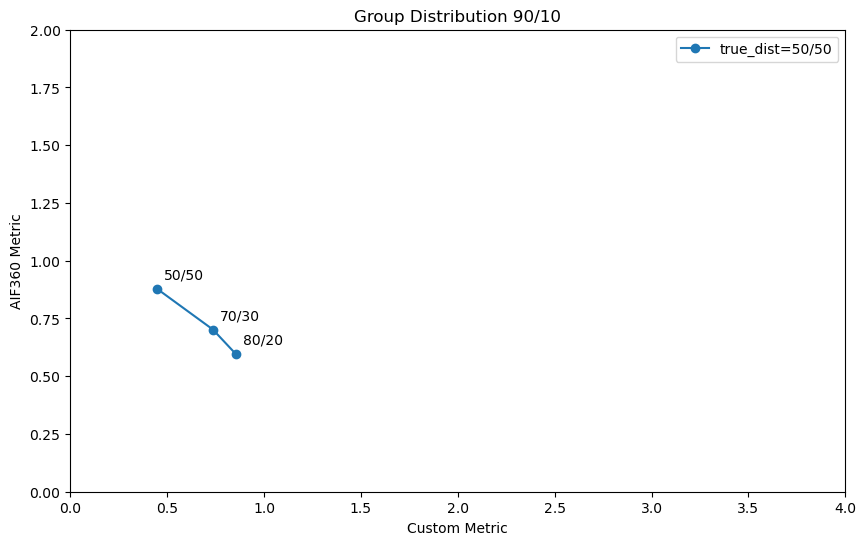

In [24]:
#filter dataframe to get rows where grp and true are fixed to 50/50 and pred is being varied. 
#and then index the columns of interest that are being plotted for the test.
df_filtered = random_metrics_scores_table[
    (random_metrics_scores_table['grp_dist'] == '90/10') &
    (random_metrics_scores_table['true_dist']) &
    (random_metrics_scores_table['pred_dist'])
] [['grp_dist', 'true_dist', 'pred_dist', 'Custom Metric', 'disparate_impact']]

partial_plotting = df_filtered.iloc[:4] #plot all rows where grp,true will be 50/50 and pred is varying

plt.figure(figsize=(10, 6))

for dist_value, group_data in partial_plotting.groupby('true_dist'):
    print(dist_value, group_data)
    # Sort by x-axis column so lines go from left to right
    group_data = group_data.sort_values(by='Custom Metric')
    
    plt.plot(
        group_data['Custom Metric'],
        group_data['disparate_impact'],
        marker='o', linestyle='-', label=f"true_dist={dist_value}"
    )
    
    #labelling the points to have the pred_dist value on them
    for idx, row in group_data.iterrows():
        #print(idx, row)
        plt.annotate(
            text=f"{row['pred_dist']}",
            xy=(row['Custom Metric'], row['disparate_impact']),
            xytext=(5, 5), 
            textcoords="offset points",
            ha='left',
            va='bottom'
        )

plt.xlabel('Custom Metric')
plt.ylabel('AIF360 Metric')
plt.title('Group Distribution 90/10')
plt.xlim(0, 4)
plt.ylim(0, 2)
plt.legend()
plt.show()

### plot_metrics() function

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(df, filter_df, x_axis, y_axis, groupby_col, pred_annotations,
                      title='Group Distribution', xlabel=None, ylabel=None, xlim=None, ylim=None, figsize=(10,6)):
    # Create a boolean mask based on the filter_df
    mask = pd.Series(True, index=df.index)
    for column, value in filter_df.items():
        mask &= (df[column] == value)
    
    df_filtered = df[mask]

    #select the columns to plot
    df_filtered = df_filtered[[x_axis, y_axis, groupby_col, pred_annotations]]
    
    plt.figure(figsize=figsize)
    
    #Group by true_dist column and plot a line for each accordingly
    for group_value, group_data in df_filtered.groupby(groupby_col):
        #Sort the data so the line connects points in order
        group_data = group_data.sort_values(by=x_axis)

        #legend should show the different true label distribution lines for the plotted group distribution 
        legend_label = f" true_dist={group_value}"
        
        plt.plot(
            group_data[x_axis],
            group_data[y_axis],
            marker='o', linestyle='-',
            label=legend_label
        )
        #each datapoint should be labelled with the changing pred_dist value it corresponds to 
        for i, row in group_data.iterrows():
            plt.annotate(
                text=str(row[pred_annotations]),
                xy=(row[x_axis], row[y_axis]),
                xytext=(5, 5),
                textcoords="offset points",
                ha='left',
                va='bottom'
            )
    
    plt.xlabel(xlabel if xlabel else x_axis)
    plt.ylabel(ylabel if ylabel else y_axis)
    plt.title(title)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.legend()
    plt.show()